# Bridging the gap: model mixing with Gaussian processes

## Alexandra Semposki

### Date: 29 October 2021

---

## GPs with scikit learn

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mixing import Mixing, Switching, Models
from discrepancy import Discrepancy
from gaussprocess import GP#, Diagnostics

matplotlib.rcParams.update({
   'font.family': 'serif',
   'text.usetex': True,
})

Welcome to the BMM sandbox! Here you get to play!
Select a dpi for the figure.100

y-limits (enter "auto" if unknown): auto


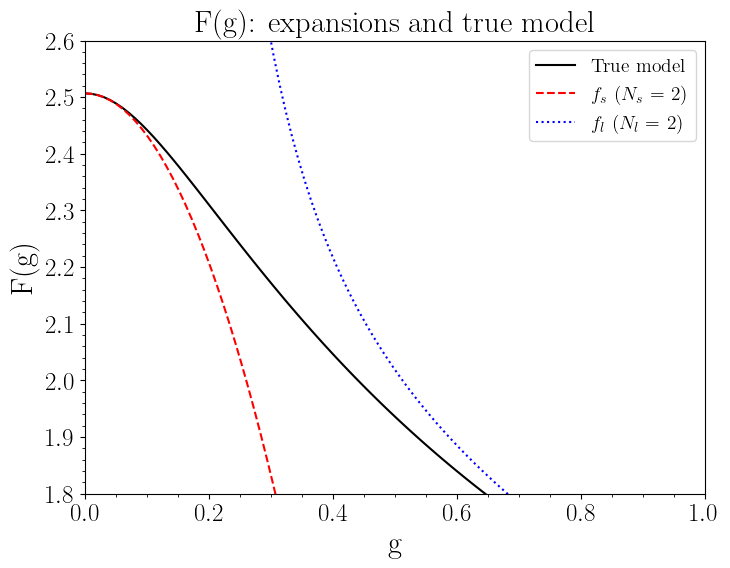

Would you like to save this figure? (yes/no)no


In [2]:
# first we need to see which models we want to mix
models = Mixing()
g = np.linspace(1e-6, 1.0, 100)
low = np.array([2])
high = np.array([2])
models.plot_models(g, low, high)

In [3]:
# begin by calling the GP class just to see if it works
new = GP(g, kernel="RBF", fix_length=False)

Initializing standard Constant * RBF kernel.


After loading the GP we wish to get some data from the models and try to emulate between the two. Let's take some data and plot it.

Which error model do you want to use? (uninformative/informative)informative

Small-g expansion: error will be on the order of g^4.
[ 0.         0.        -0.4699928  0.       ]
Large-g expansion: error will be of the order g^3.
[ 1.81280495 -1.08599728  0.90640248]
(4,)
[0.0656575 0.1161625 0.6111115 0.6818185]
Optimized parameters: 2.49**2, RBF(length_scale=0.931)


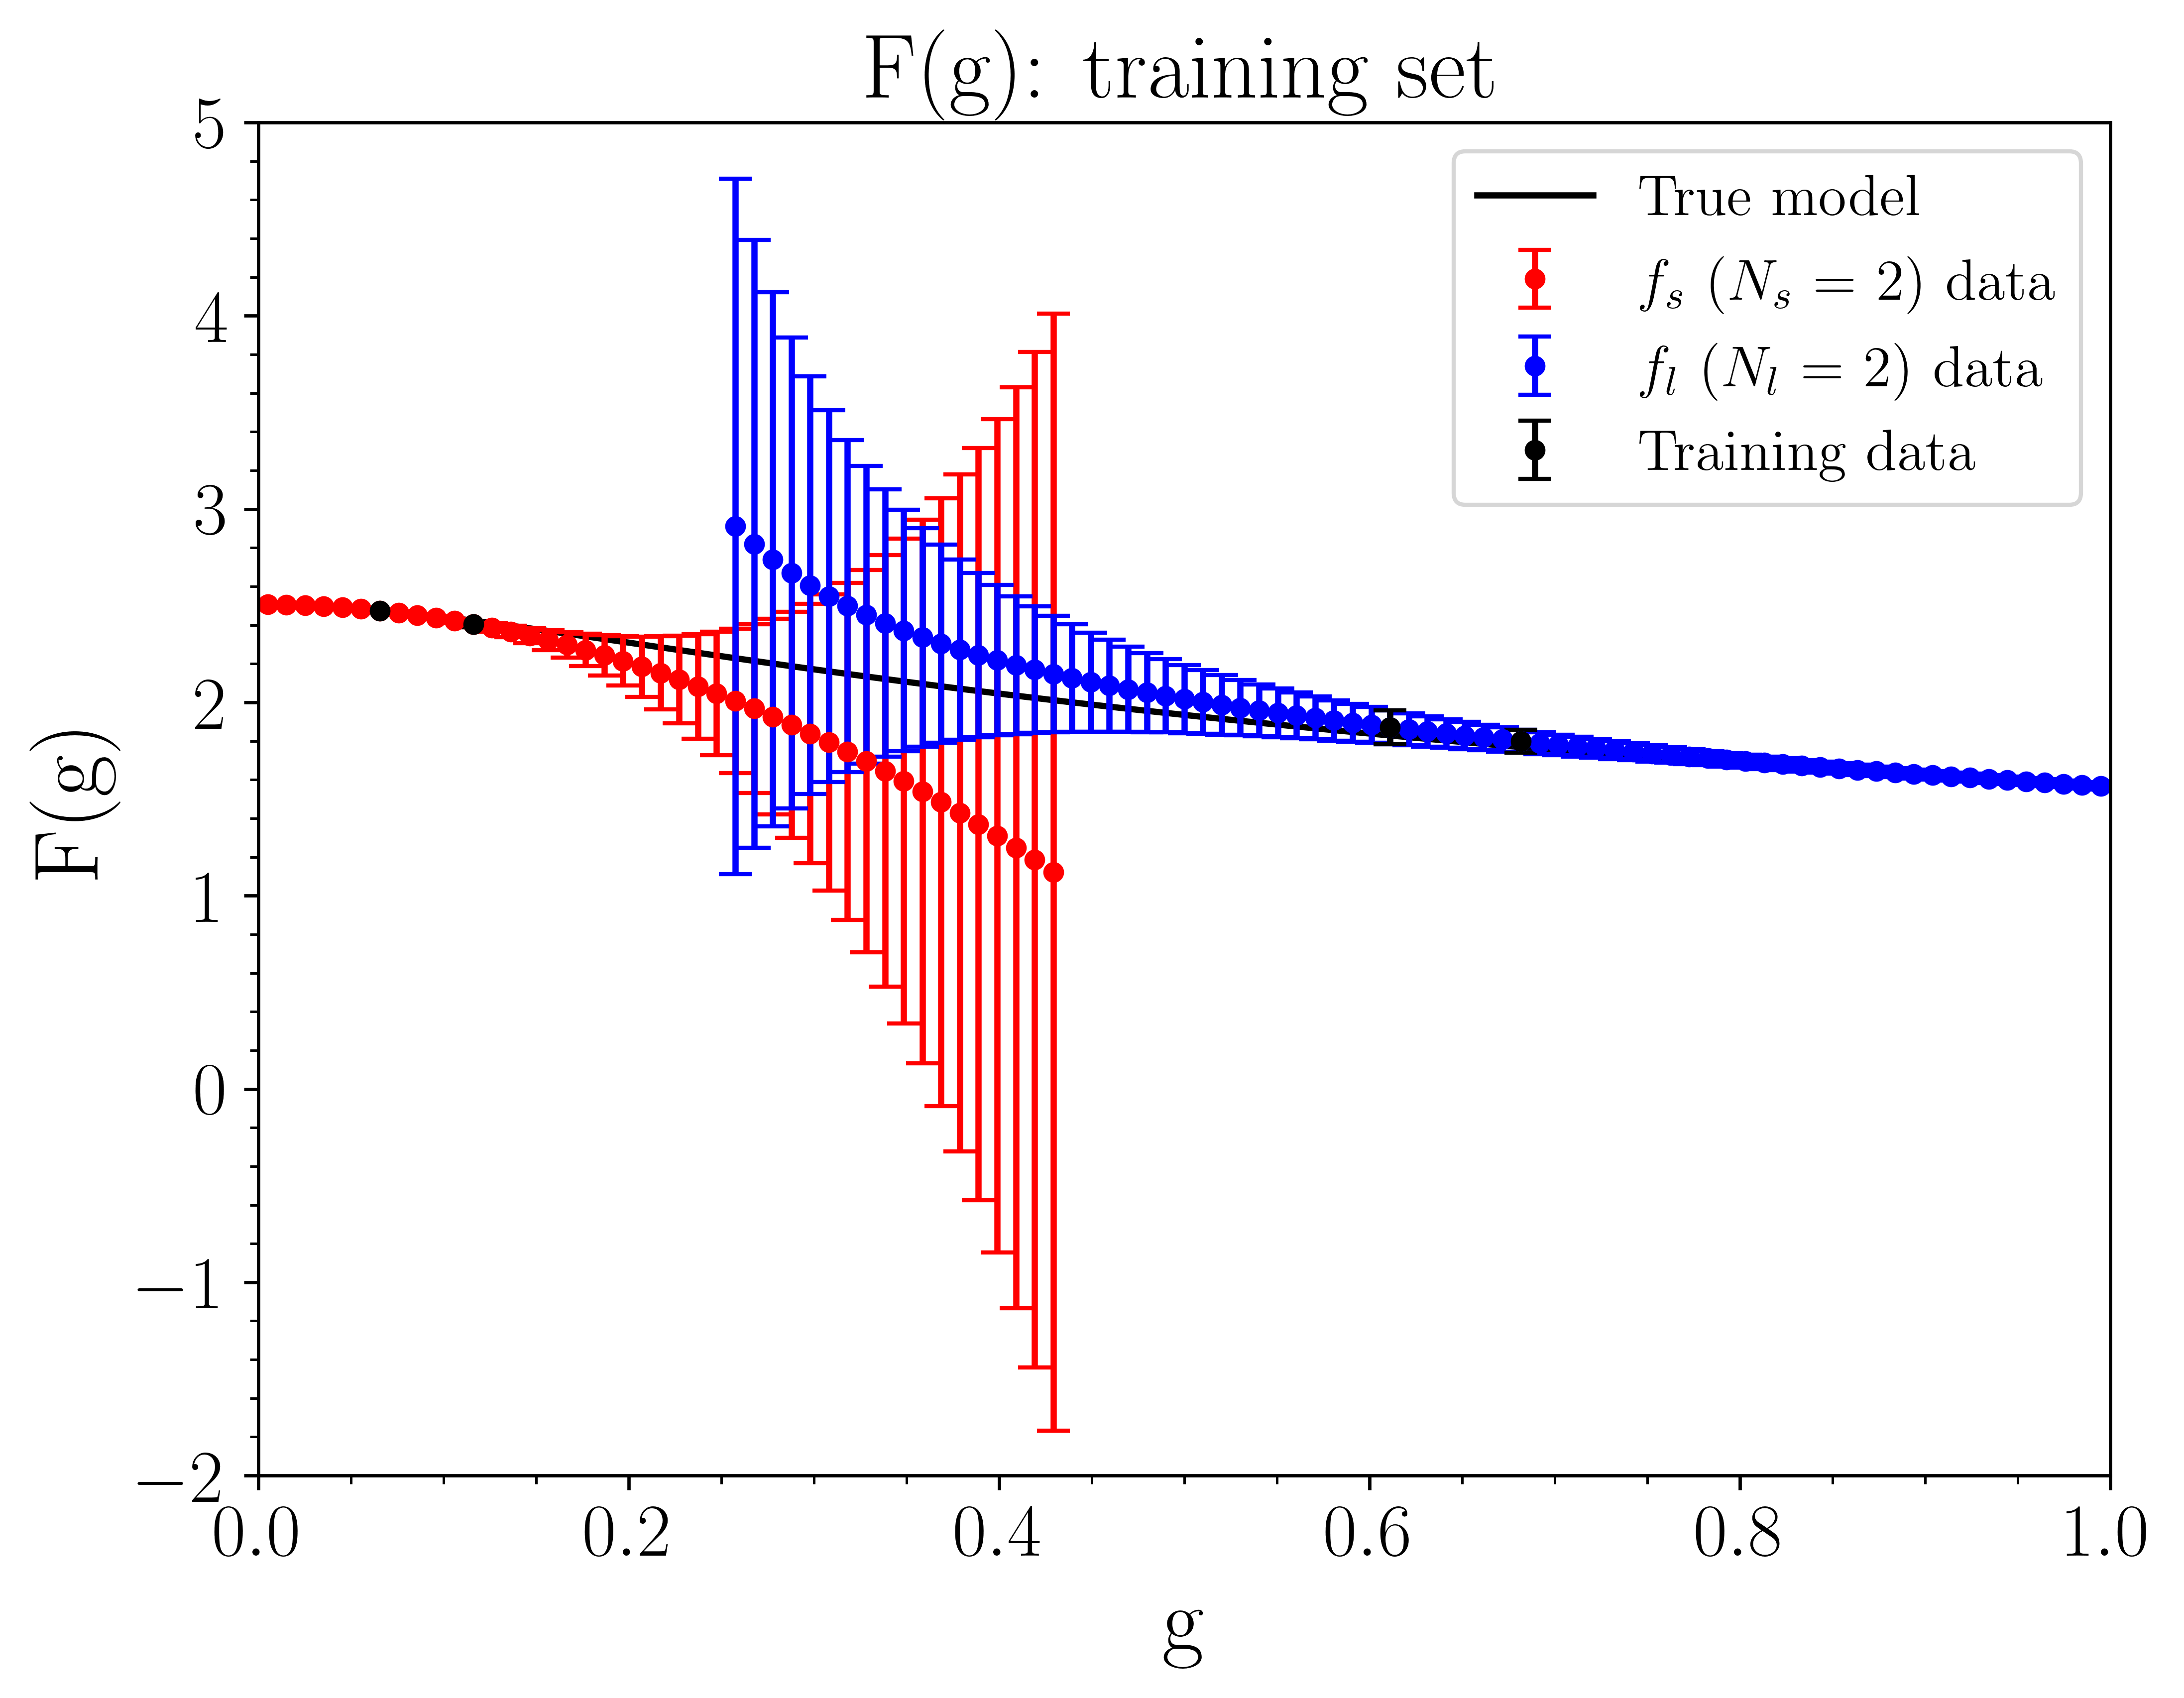

Would you like to save this figure? (yes/no)no
Which error model do you want to use? (uninformative/informative)informative

Small-g expansion: error will be on the order of g^4.
[ 0.         0.        -0.4699928  0.       ]
Large-g expansion: error will be of the order g^3.
[ 1.81280495 -1.08599728  0.90640248]


In [4]:
trained, uncov = new.training(low, high, error=True)
gs, datas, sigmas = new.training_set(low, high)

In [5]:
# print the uncov
print(uncov) #need to undo normalization don't I...?

[[6.17749609 6.16841468 5.20342351 4.96267735]
 [6.16841468 6.17749609 5.36353192 5.13649304]
 [5.20342351 5.36353192 6.17749609 6.15970909]
 [4.96267735 5.13649304 6.15970909 6.17749609]]



Small-g expansion: error will be on the order of g^4.
[ 0.         0.        -0.4699928  0.       ]
Large-g expansion: error will be of the order g^3.
[ 1.81280495 -1.08599728  0.90640248]


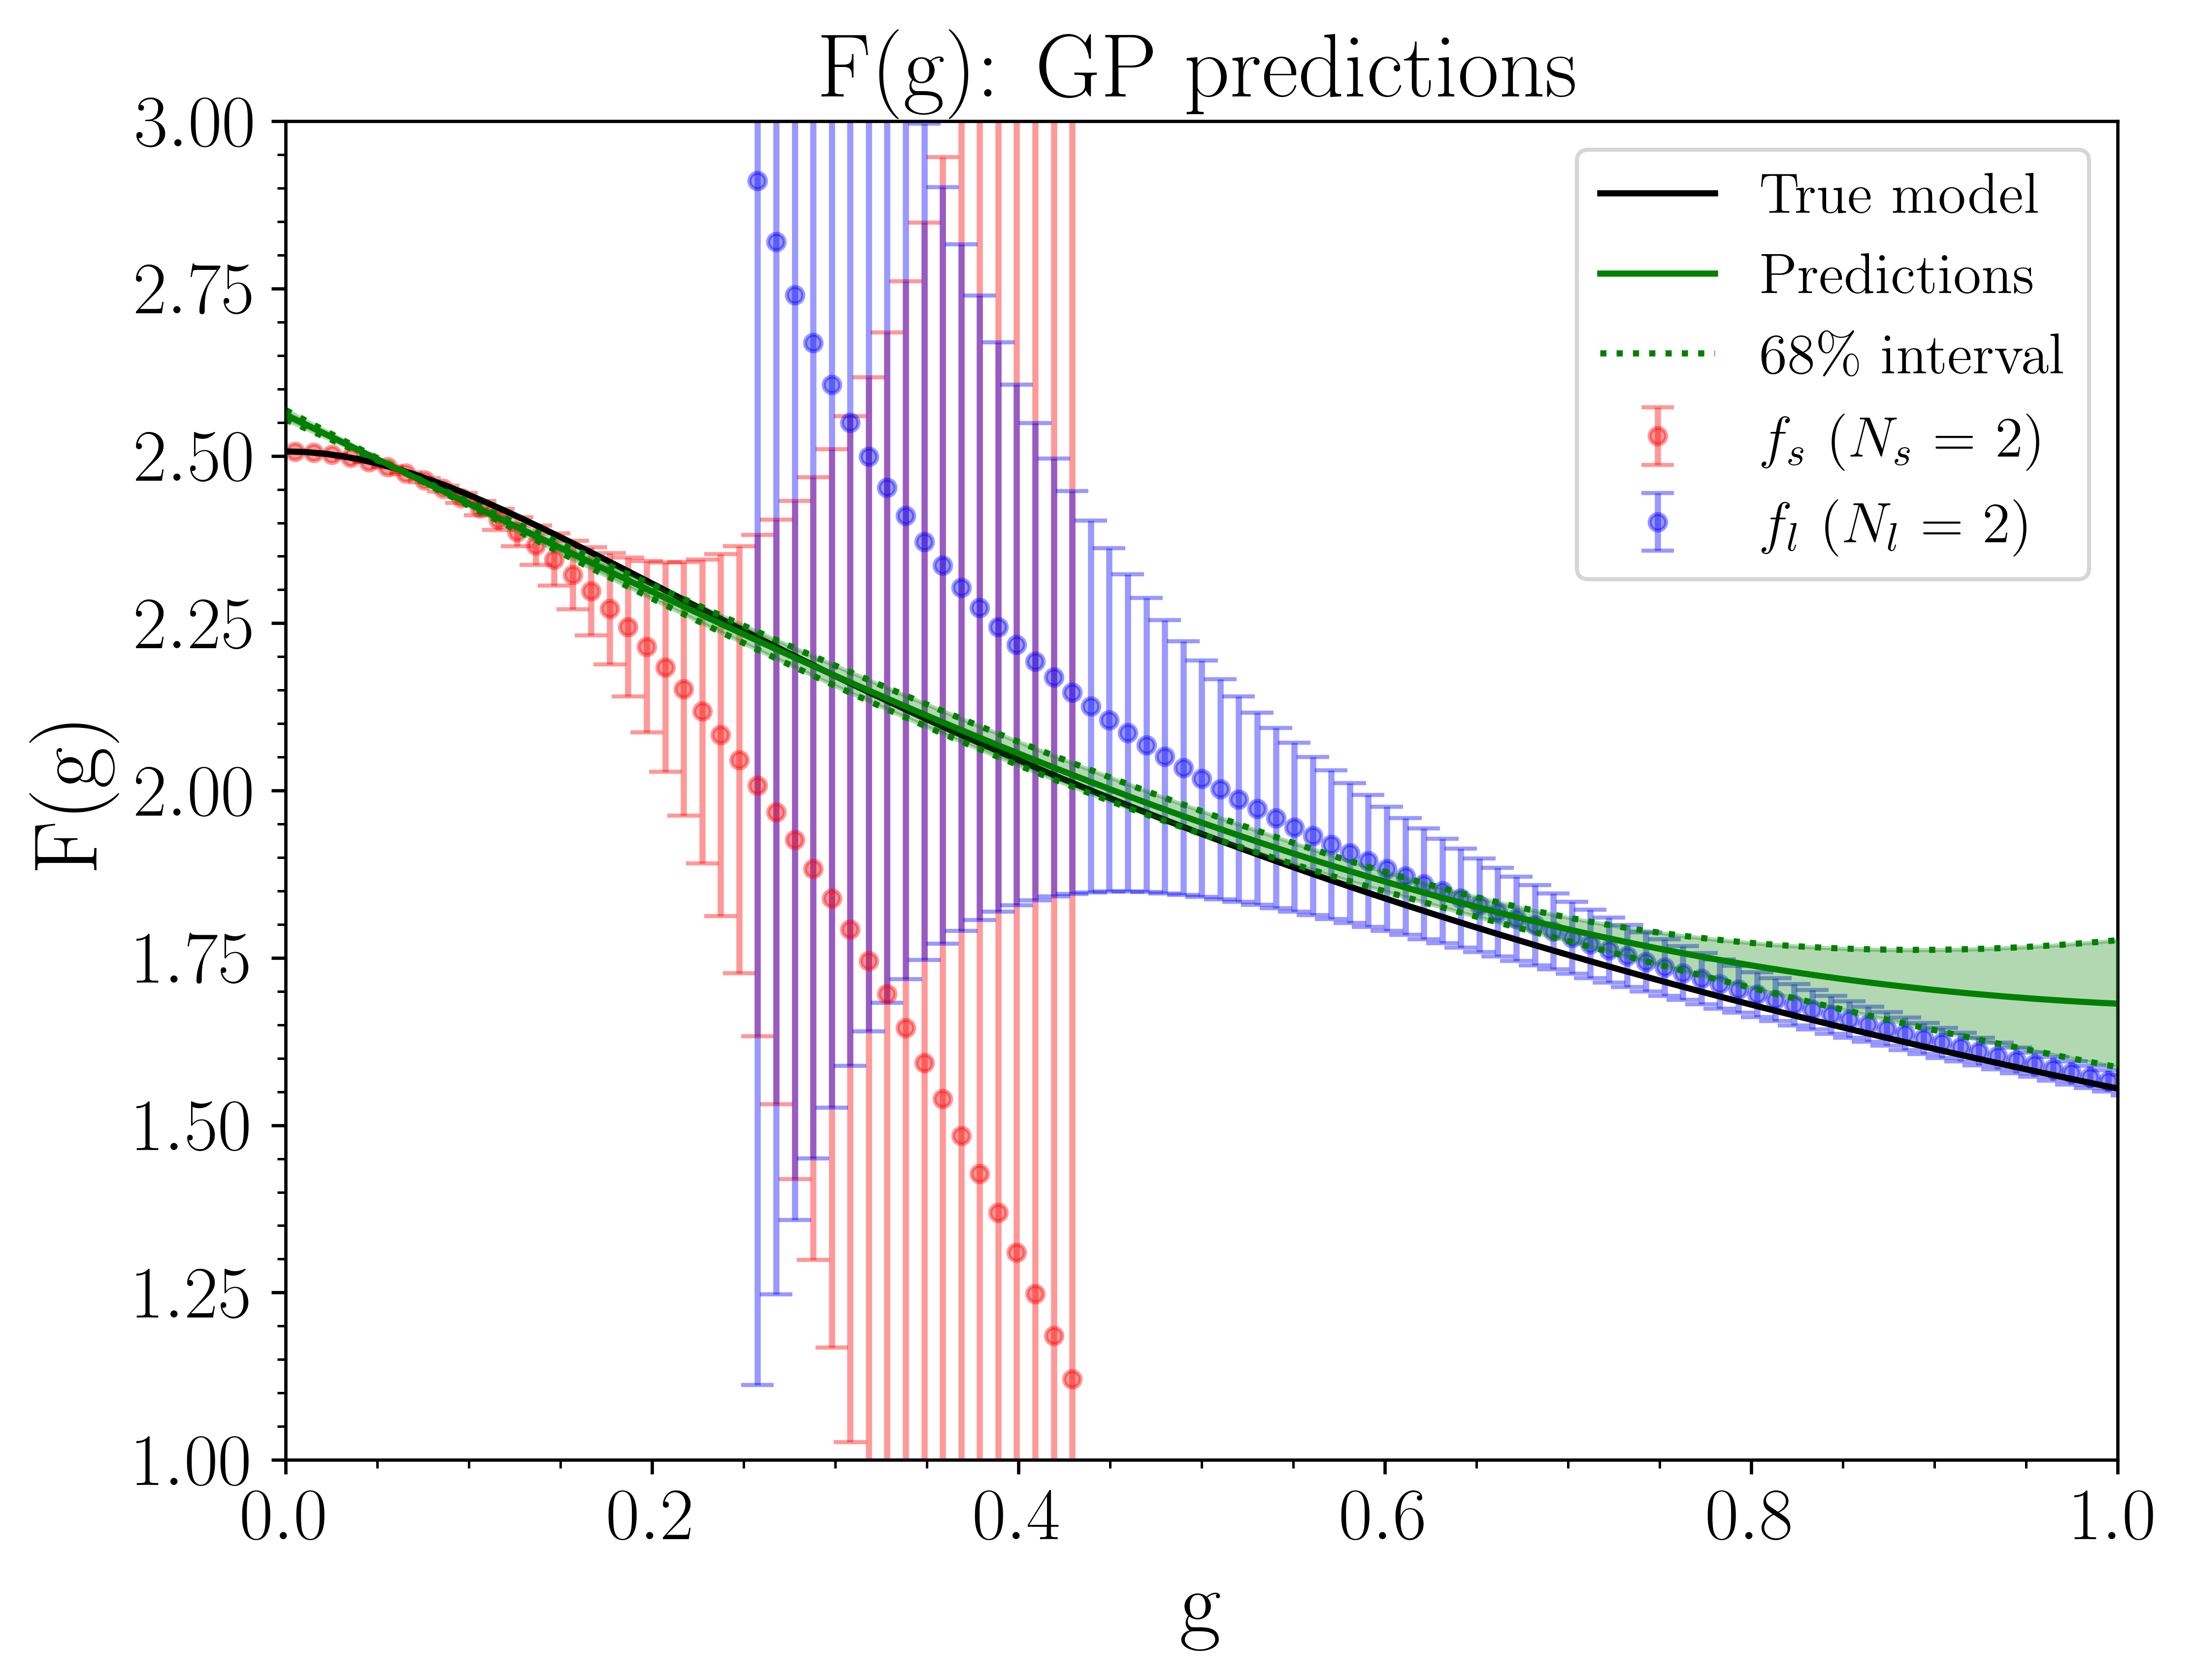

Would you like to save this figure? (yes/no)no


In [6]:
mean, sig, cov = new.validate(trained, low, high, interval=68)
#print(np.diag(cov))
#print(sig) #definitely the STANDARD DEVIATION!

In [7]:
# md_g, md_mean, md_sig, md_cov = new.MD_set(sigmas)

# #try to add small variance to cov to make it less singular
# md_cov = md_cov + 0.001*np.eye(len(md_cov))

# #thin the prediction set to every 10 entries to try ref dist
# md_gthin = md_g[::3]
# md_meanthin = md_mean[::3]
# md_sigthin = md_sig[::3]
# md_covthin = md_cov[::3,::3]

# print(np.shape(md_gthin))

In [8]:
#access and print the values of the std dev for testing and for the model predictions
# stdev_models = np.concatenate((new.stdev_low, new.stdev_high))
# print('   GP error  | Expansion error')
# for i in range(len(stdev_models)):
#     print('  {:.8f} |   {:.8f}'.format(sig[i], stdev_models[i]))

In [9]:
#call the Discrepancy plotting function for 3 models
newplot = Discrepancy()
print(mean)
print(np.shape(mean))
print(mean.reshape(-1,1).T)

[2.56125044 2.54791572 2.5345524  2.52116528 2.50775914 2.49433876
 2.48090892 2.46747438 2.45403989 2.4406102  2.42719    2.41378401
 2.40039688 2.38703327 2.37369778 2.36039499 2.34712946 2.33390569
 2.32072815 2.30760125 2.29452939 2.28151689 2.26856804 2.25568706
 2.24287812 2.23014535 2.2174928  2.20492447 2.19244428 2.18005612
 2.16776377 2.15557097 2.14348137 2.13149857 2.11962606 2.1078673
 2.09622563 2.08470433 2.07330659 2.06203554 2.0508942  2.03988551
 2.02901234 2.01827745 2.00768353 1.99723317 1.98692888 1.97677307
 1.96676807 1.95691609 1.94721928 1.93767968 1.92829924 1.91907981
 1.91002316 1.90113094 1.89240474 1.88384601 1.87545616 1.86723645
 1.85918809 1.85131216 1.84360967 1.83608153 1.82872855 1.82155144
 1.81455085 1.80772729 1.80108123 1.794613   1.78832288 1.78221104
 1.77627756 1.77052244 1.7649456  1.75954686 1.75432597 1.74928257
 1.74441626 1.73972653 1.73521279 1.73087439 1.72671059 1.72272057
 1.71890345 1.71525827 1.71178401 1.70847955 1.70534374 1.70237

In [10]:
# g_plot = np.linspace(1e-6, 1.0, 100)
# newplot.plot_mix(g_plot, low, high, plot_fdagger=True, GP_mean=mean, GP_var=np.square(sig))

In [11]:
# newplot.subplot_mix(g_plot, np.array([2]), np.array([2]), GP_mean=mean, GP_var=np.square(sig))

---

## Diagnostics

In [12]:
#import cholesky in case of need
from numpy.linalg import cholesky
import scipy.linalg as scl

#pull samples from a reference distribution
def ref_dist(mean, cov, random_state=1):
    
    dist = stats.multivariate_normal(mean=mean, cov=cov)
    
    return dist

def sample_ref(dist, n_curves):
    
    samples = dist.rvs(n_curves).T
    
    return samples

def chol_cov(cov):
    
    chol = cholesky(cov)
    
    return chol

def chol_errors(y, mean, chol):
    
    return scl.solve_triangular(chol, (y - mean).T, lower=True).T

#calculate the MD for each curve and our specific curve
def mahalanobis(y, mean, inv=None, chol=None, svd=False):
    
    y = np.atleast_2d(y)
    
    #if chol is selected
    if (inv is None) and (chol is not None):
        errs = chol_errors(y, mean, chol)
        return np.linalg.norm(errs, axis=-1)
    
    #if svd is selected
    if (svd is True):
        
        #perform SVD
        u, s, vh = np.linalg.svd(md_cov)
        svd_errs = np.sqrt(s)**(-1.0) * u @ (y-mean).T
        svd_md = np.sum(np.square(svd_errs))
        print('SVD Errors', svd_errs.T)
        print('MD (SVD): ', svd_md)
                
    #if inv is selected
    if (chol is None) and (inv is not None):
        md = np.squeeze(np.sqrt(np.diag((y - mean) @ np.linalg.pinv(inv) @ (y - mean).T)))
        return md
        
    #if both are selected
    if (chol is not None) and (inv is not None):
        raise ValueError('Send either the cholesky matrix or covariance matrix, not both.')

11
80
5 [[ 1.63882982e-05  5.14317322e-05  5.52474509e-05  3.00469506e-05
  -1.78096841e-05]
 [ 5.14317322e-05  1.84829901e-04  2.26245052e-04  1.47027464e-04
  -6.08938714e-05]
 [ 5.52474509e-05  2.26245052e-04  3.10996160e-04  2.37655130e-04
  -3.76694918e-05]
 [ 3.00469506e-05  1.47027464e-04  2.37655130e-04  2.37651304e-04
   9.82923494e-05]
 [-1.78096841e-05 -6.08938714e-05 -3.76694918e-05  9.82923494e-05
   3.75728204e-04]]


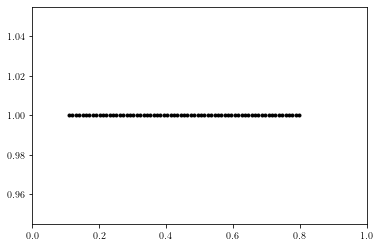

In [14]:
md_g, md_mean, md_sig, md_cov = new.MD_set()

#check the size of the theory errors for comparison to the nugget
#print(sigmas**2.0, np.shape(sigmas))

#try to add small variance to cov to make it less singular
md_cov = md_cov #+ 1e-6*np.eye(len(md_cov))

#thin the prediction set to every 10 entries to try ref dist
md_g = md_g[::15]
md_mean = md_mean[::15]
md_sig = md_sig[::15]
md_cov = md_cov[::15,::15]

npts = len(md_g)

print(len(md_g), md_cov)

[[ 1.63882982e-05  5.14317322e-05  5.52474509e-05  3.00469506e-05
  -1.78096841e-05]
 [ 5.14317322e-05  1.84829901e-04  2.26245052e-04  1.47027464e-04
  -6.08938714e-05]
 [ 5.52474509e-05  2.26245052e-04  3.10996160e-04  2.37655130e-04
  -3.76694918e-05]
 [ 3.00469506e-05  1.47027464e-04  2.37655130e-04  2.37651304e-04
   9.82923494e-05]
 [-1.78096841e-05 -6.08938714e-05 -3.76694918e-05  9.82923494e-05
   3.75728204e-04]]
Diagonal [0.00404825 0.01359522 0.01763508 0.01541594 0.01938371]
Condition number 25948.6361735533
SVD Errors [[ 164.24974895 -147.21527813  121.02744239  -55.80210973   10.83733546]]
MD (SVD):  66529.2832455998
28.90025061281352
Squared MD for our GP: 835.2244854834282
Min of array: 0.23555391715819396; max of array: 24.041331277143883


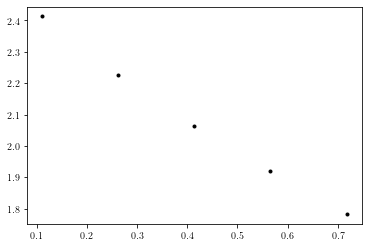

In [15]:
#compute cholesky 
chol = cholesky(md_cov)
matrix = chol @ chol.conj().T
print(matrix)
print('Diagonal', np.sqrt(np.diagonal((md_cov))))
print('Condition number', np.linalg.cond(md_cov))

#generate MDs of the reference distribution
dist = ref_dist(md_mean, md_cov, random_state=1)
n_curves = 1000
y = sample_ref(dist, n_curves)
md = np.ones([n_curves])
for i in range(n_curves):
    md[i] = mahalanobis(y[:,i].T, md_mean, inv=md_cov, chol=None, svd=False)
    
#square the reference distribution MD
md2 = md**2.0 

#now calculate our specific value of the MD
model = Models()
fval = model.true_model(md_g)
md_gp = mahalanobis(fval.T, md_mean, inv=md_cov, chol=None, svd=True)
print(md_gp)
md_gp2 = md_gp**2.0

#print out the values of each 
# print('Squared Mahalanobis array:', md**2.0)
print('Squared MD for our GP:', md_gp**2.0)
print('Min of array: {}; max of array: {}'.format(min(md**2.0), max(md**2.0)))

plt.plot(md_g, y[:,i].T, 'k.')

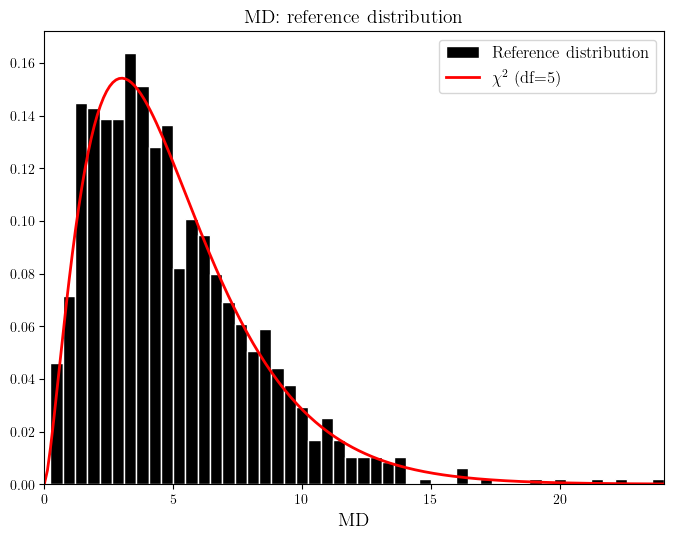

4.932201810960103 3.204128914922286


In [16]:
#plot the reference distribution histogram
fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes()
ax.set_xlabel('MD', fontsize=14)
ax.set_title('MD: reference distribution', fontsize=14)
ax.set_xlim(0.0, max(md2))
histogram_data = ax.hist(md2, bins=50, density=True, histtype='bar', facecolor='black', ec='white', label='Reference distribution')
ax.plot(md_gp2, 0.0, 'r', marker='o', markersize=10)

#plot the chi-squared distribution over this histogram
ax.plot(np.linspace(0.0,max(md2),200), stats.chi2.pdf(np.linspace(0.0,max(md2),200), df=npts), 'r', linewidth=2, label=r'$\chi^2$ (df={})'.format(npts))
ax.legend(loc='upper right', fontsize=12)
plt.show()

#mean
print(np.mean(md2), np.std(md2))

In [17]:
#develop MD plotter and copy into the class
def md_plotter(g, npts, md_gp, md_ref, hist=True, box=False):
    
    #setup
    fig = plt.figure(figsize=(8,6), dpi=600)
    ax = plt.axes()
    ax.set_xlabel(r'$\mathrm{MD}^{2}$', fontsize=18)
    ax.set_title('Mahalanobis distance', fontsize=22)
    ax.set_xlim(0.0, max(md_ref))
    
    #histogram option
    if hist is True:
        ax.hist(md_ref, bins=50, density=True, histtype='bar', facecolor='black', \
                ec='white', label='Reference distribution')
        ax.plot(md_gp, 0.0, marker='o', color='r', markersize=10)

        #add chi-squared to histogram
        n = 200
        x = np.linspace(0.0, max(md_ref), n)
        ax.plot(x, stats.chi2.pdf(x, df=npts), 'r', linewidth=2, label=r'$\chi^2$ (df={})'.format(npts))

    #box-and-whisker option
    if box is True:
        print('Not yet implemented.')
    
    #finish up plot
    ax.legend(loc='upper right', fontsize=16)
    plt.show()
    
    return None

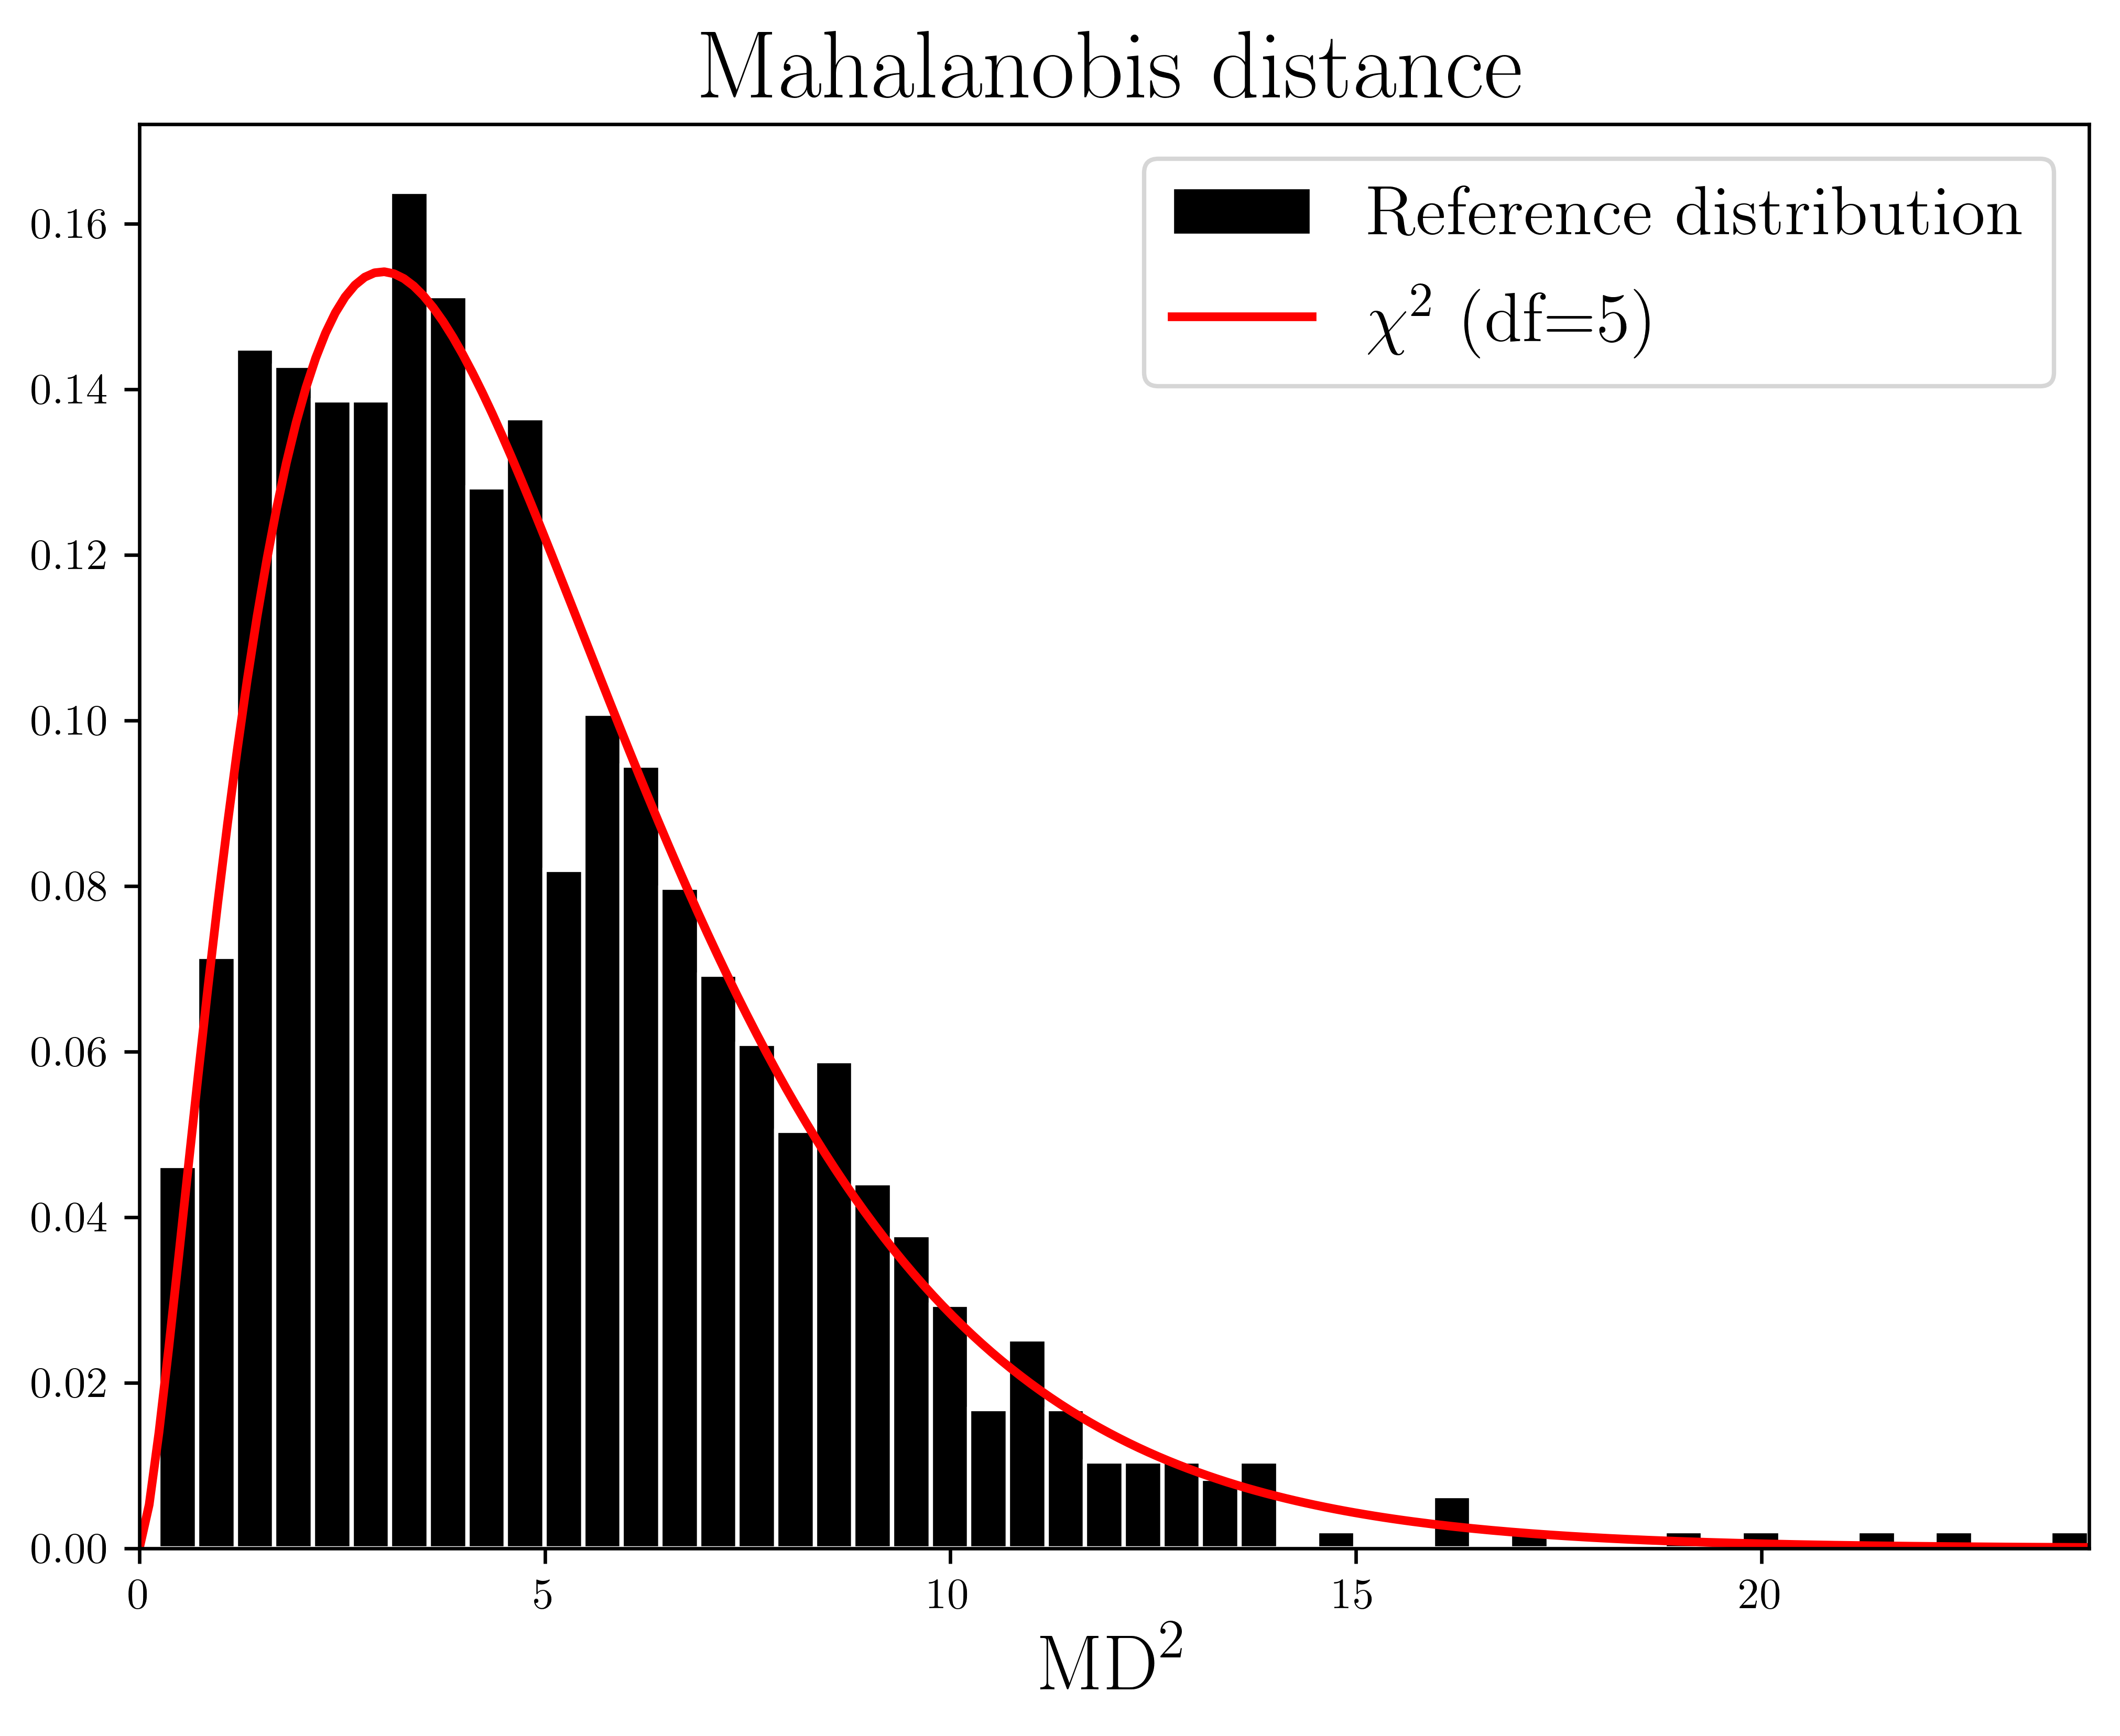

In [18]:
#try the function out
md_plotter(md_g, npts, md_gp2, md2, hist=True, box=False)

__TO DO__:

- Form the Diagnostics() method class 
- Finish the plotter for MD (histogram option and box and whisker option)
- Determine which class is the Super() (probably Models) and how to work through its children to inherit everything correctly
- Eliminate the variance questioning (move the selection to the initial object and keep throughout the use of the class)
- Finish the plotter function that will serve as a super plotter for the GP class
- Common questions (saving figures...dpi...etc) moved to one code section to cut down on repetition? Or set this when we call the plotting function manually (user enters as an argument). 

# Super() class ideas: need to implement this so that one of them is the overarching class that everyone else inherits from. Main super class is Models. Next main one would probably be GP. 